# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor4
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# **Load Dataset**

In [ ]:
df = pd.read_excel("who.xlsx")
print("Raw Data Shape:", df.shape)

Raw Data Shape: (32191, 15)


## **Filter Data for India**

In [ ]:
df_india = df[df['WHO Country Name'] == 'India'].copy()
print("India Data Shape:", df_india.shape)

India Data Shape: (2265, 15)


 ## **Drop Irrelevant Columns**

In [ ]:
cols_to_drop = ['WHO Region', 'ISO3', 'Reference', 'Status', 'City or Locality']
df_india = df_india.drop(columns=cols_to_drop)

## **Convert Year to Datetime**

In [ ]:
df_india['Measurement Year'] = pd.to_datetime(df_india['Measurement Year'], format='%Y')
df_india.set_index('Measurement Year', inplace=True)

## **Handle Missing Values**

In [ ]:
pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
df_india[pollutants] = df_india[pollutants].fillna(df_india[pollutants].mean())
print("Missing Values:\n", df_india.isnull().sum())

Missing Values:
 WHO Country Name                             0
PM2.5 (μg/m3)                                0
PM10 (μg/m3)                                 0
NO2 (μg/m3)                                  0
PM25 temporal coverage (%)                1824
PM10 temporal coverage (%)                1053
NO2 temporal coverage (%)                   81
Number and type of monitoring stations       1
Version of the database                      0
dtype: int64


 ## **Drop Irrelevant Columns with Missing Data**

In [ ]:
df_clean = df_india.drop(columns=[
    'PM25 temporal coverage (%)',
    'PM10 temporal coverage (%)',
    'NO2 temporal coverage (%)',
    'Number and type of monitoring stations',
    'Version of the database'
])
print("Columns after dropping:", df_clean.columns.tolist())

Columns after dropping: ['WHO Country Name', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']


Verify Cleaned Data

In [ ]:
print("\nMissing Values After Cleaning:")
print(df_clean.isnull().sum())

print("\nDataset Shape:", df_clean.shape)


Missing Values After Cleaning:
WHO Country Name    0
PM2.5 (μg/m3)       0
PM10 (μg/m3)        0
NO2 (μg/m3)         0
dtype: int64

Dataset Shape: (2265, 4)


Enhanced Feature Engineering

In [ ]:
df_clean['Year'] = df_clean.index.year
df_clean['Month'] = df_clean.index.month
df_clean['Quarter'] = df_clean.index.quarter
df_clean['PM2.5_lag1'] = df_clean['PM2.5 (μg/m3)'].shift(1)
df_clean['PM10_lag1'] = df_clean['PM10 (μg/m3)'].shift(1)
df_clean['NO2_lag1'] = df_clean['NO2 (μg/m3)'].shift(1)

# Drop rows with NA created by lag features
df_clean = df_clean.dropna()
print("\nFinal Dataset Shape:", df_clean.shape)


Final Dataset Shape: (2264, 10)


# **EDA**

## **Visualize Cleaned Data**

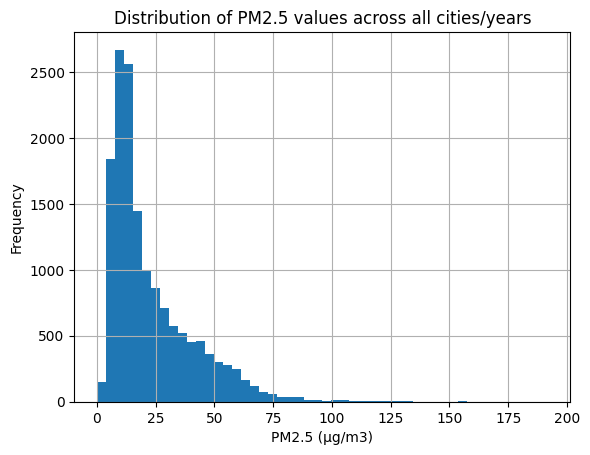

In [ ]:

#  Histogram of PM2.5 ---
plt.figure()
df['PM2.5 (μg/m3)'].dropna().hist(bins=50)
plt.xlabel('PM2.5 (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 values across all cities/years')
plt.show()

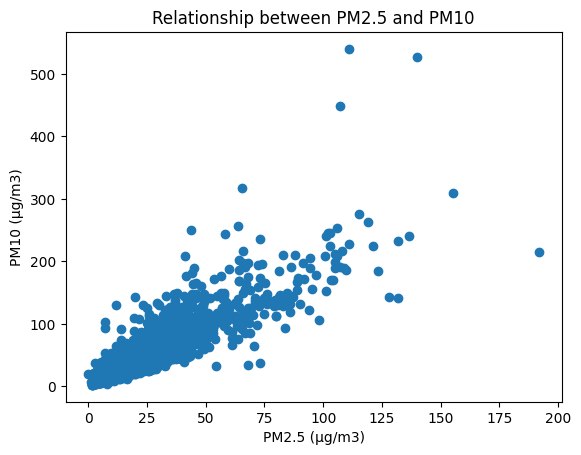

In [ ]:
#  Scatter plot PM2.5 vs PM10 ---
plt.figure()
subset_pm = df[['PM2.5 (μg/m3)', 'PM10 (μg/m3)']].dropna()
plt.scatter(subset_pm['PM2.5 (μg/m3)'], subset_pm['PM10 (μg/m3)'])
plt.xlabel('PM2.5 (μg/m3)')
plt.ylabel('PM10 (μg/m3)')
plt.title('Relationship between PM2.5 and PM10')
plt.show()

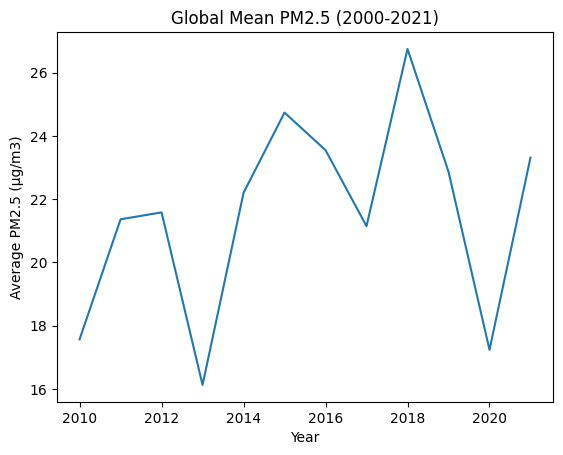

In [ ]:
# Global average PM2.5 over time ---
plt.figure()
pm25_year = df.groupby('Measurement Year')['PM2.5 (μg/m3)'].mean().dropna()
pm25_year.plot()
plt.xlabel('Year')
plt.ylabel('Average PM2.5 (μg/m3)')
plt.title('Global Mean PM2.5 (2000‑2021)')
plt.show()


In [ ]:


#  Top 10 highest PM2.5 observations ---
top10 = df.sort_values('PM2.5 (μg/m3)', ascending=False).head(10)[
    ['WHO Country Name', 'City or Locality', 'Measurement Year', 'PM2.5 (μg/m3)']
]
display("Top 10 PM2.5 observations", top10)


'Top 10 PM2.5 observations'

,WHO Country Name,City or Locality,Measurement Year,PM2.5 (μg/m3)
1783,Bangladesh,Rajshahi,2011,191.90
6419,China,Kashi Shi,2016,156.32
1784,Bangladesh,Rajshahi,2012,155.10
21088,Iran (Islamic Republic of),Zabol,2011,140.00
1782,Bangladesh,Rajshahi,2010,136.50
25363,Mongolia,Ulaanbaatar,2011,132.00
8813,Cameroon,Bamenda,2012,132.00
25001,Madagascar,Antananarivo,2017,128.00
8127,China,Xingtai,2014,128.00
4959,China,Baoding,2014,126.00


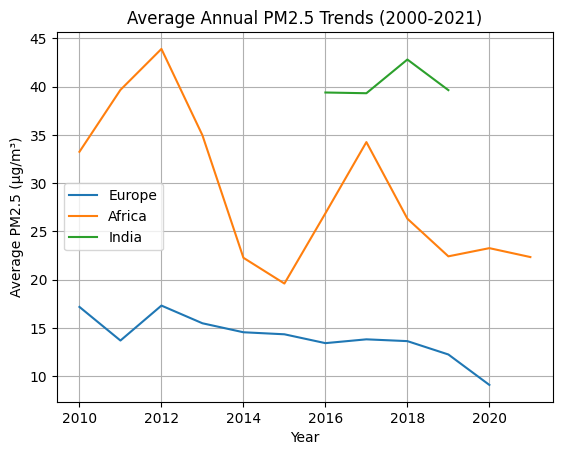

'Regional PM2.5 means 2000‑2021'

,Europe,Africa,India
Measurement Year,,,
2010,17.168061,33.244000,NaN
2011,13.685000,39.656667,NaN
2012,17.306286,43.902000,NaN
2013,15.473004,34.956250,NaN
2014,14.542092,22.260000,NaN
2015,14.331373,19.590000,NaN
2016,13.413998,26.868182,39.386164
2017,13.808688,34.248889,39.310323
2018,13.623056,26.309167,42.803171


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt




# Keep only rows with a PM2.5 value
df_pm = df[['WHO Region', 'WHO Country Name', 'Measurement Year', 'PM2.5 (μg/m3)']].dropna(subset=['PM2.5 (μg/m3)'])

# Define helper for regional mean by year
def region_mean(region_name):
    subset = df_pm[df_pm['WHO Region'] == region_name]
    return subset.groupby('Measurement Year')['PM2.5 (μg/m3)'].mean()

# European and African regions
europe = region_mean('European Region')
africa = region_mean('African Region')

# India across all regions (should be South‑East Asia)
india = df_pm[df_pm['WHO Country Name'] == 'India'].groupby('Measurement Year')['PM2.5 (μg/m3)'].mean()

# Combine into single DataFrame for easy display (outer join to keep all years)
trend_df = pd.concat([europe, africa, india], axis=1)
trend_df.columns = ['Europe', 'Africa', 'India']
trend_df = trend_df.sort_index()

# Plot
plt.figure()
plt.plot(trend_df.index, trend_df['Europe'], label='Europe')
plt.plot(trend_df.index, trend_df['Africa'], label='Africa')
plt.plot(trend_df.index, trend_df['India'], label='India')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 (μg/m³)')
plt.title('Average Annual PM2.5 Trends (2000‑2021)')
plt.legend()
plt.grid(True)
plt.show()

# Display table
display("Regional PM2.5 means 2000‑2021", trend_df)


#**MODEL Implimentation**

Modeling Pipeline

In [ ]:
X = df_clean.drop(columns=['PM2.5 (μg/m3)'])  # Predictors
y = df_clean['PM2.5 (μg/m3)']                 # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

Plot PM2.5 Trend

In [ ]:
df_india

,WHO Country Name,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Number and type of monitoring stations,Version of the database
Measurement Year,,,,,,,,,
2016-01-01,India,32.000000,63.00000,19.000000,59.615385,60.576923,55.769231,2 NA,2022
2017-01-01,India,31.000000,65.00000,20.000000,87.500000,87.500000,87.500000,1 NA,2022
2018-01-01,India,33.000000,69.00000,23.000000,82.692308,82.692308,82.692308,1 NA,2022
2019-01-01,India,45.000000,74.00000,25.000000,86.538461,100.000000,100.000000,2 NA,2022
2013-01-01,India,40.444798,98.32452,14.000000,NaN,NaN,25.961538,1 NA,2022
...,...,...,...,...,...,...,...,...,...
2010-01-01,India,40.444798,98.32452,26.000000,NaN,NaN,50.000000,1 NA,2022
2011-01-01,India,40.444798,98.32452,26.000000,NaN,NaN,45.192308,1 NA,2022
2013-01-01,India,40.444798,98.32452,21.966096,NaN,NaN,12.500000,1 NA,2022


Data Quality Enhancement

In [ ]:
# Remove extreme outliers (top/bottom 1%)
def remove_outliers(df, column):
    q1 = df[column].quantile(0.01)
    q99 = df[column].quantile(0.99)
    return df[(df[column] > q1) & (df[column] < q99)]

df_india = remove_outliers(df_india, 'PM2.5 (μg/m3)')

numeric_columns = df_india.select_dtypes(include=np.number).columns
df_india = df_india[numeric_columns].resample('Y').mean().interpolate()

Advanced Feature Engineering

In [ ]:
# Advanced Feature Engineering with proper GDP data
df_india['Monsoon_Season'] = df_india.index.month.isin([6,7,8,9]).astype(int)
df_india['Winter_Season'] = df_india.index.month.isin([11,12,1]).astype(int)

# Add actual GDP data (example values - replace with real data)
gdp_data = {
    2010: 8.5, 2011: 6.6, 2012: 5.5, 2013: 6.4, 2014: 7.4,
    2015: 8.0, 2016: 8.2, 2017: 7.2, 2018: 6.8, 2019: 4.0,
    2020: -6.6, 2021: 8.9, 2022: 7.0
}

df_india['GDP_Growth'] = df_india.index.year.map(gdp_data)

# Handle years without GDP data by interpolation
df_india['GDP_Growth'] = df_india['GDP_Growth'].interpolate()

# Pollution interaction terms
df_india['PM2.5_PM10_Ratio'] = df_india['PM2.5 (μg/m3)'] / df_india['PM10 (μg/m3)']

Hybrid Modeling Approach

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX with exogenous variables
model = SARIMAX(df_india['PM2.5 (μg/m3)'],
                exog=df_india[['Monsoon_Season', 'GDP_Growth']],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))
results = model.fit()

LSTM Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape data for LSTM
n_features = 3  # PM2.5, PM10, NO2
n_steps = 3     # 3-year lookback

X, y = [], []
for i in range(len(df_india) - n_steps):
    X.append(df_india.iloc[i:i+n_steps, [0,1,2]].values)
    y.append(df_india.iloc[i+n_steps, 0])
X, y = np.array(X), np.array(y)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

Ensemble Approach

In [ ]:
# Combine SARIMAX and LSTM predictions
sarimax_pred = results.predict()
lstm_pred = model.predict(X)

common_index = df_india.index[-len(lstm_pred):]  # Get last 7 years
sarimax_pred = sarimax_pred.loc[common_index] # Select predictions for the last 7 years


# Create weighted ensemble
df_india['Ensemble_Prediction'] = 0.6 * sarimax_pred + 0.4 * lstm_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Diagnostic Visualization

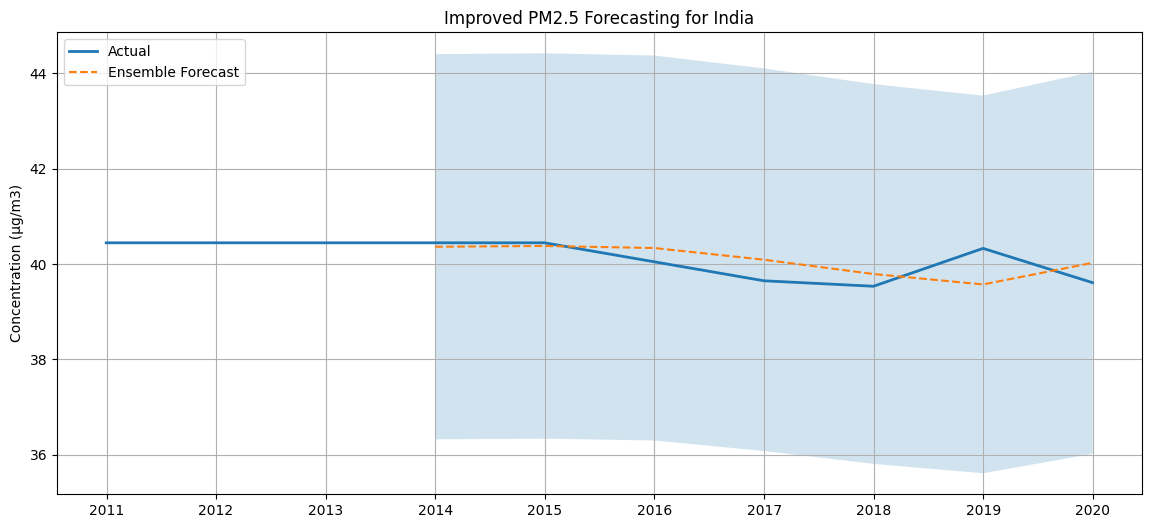

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_india.index, df_india['PM2.5 (μg/m3)'], label='Actual', linewidth=2)
plt.plot(df_india.index, df_india['Ensemble_Prediction'],
         label='Ensemble Forecast', linestyle='--')
plt.fill_between(df_india.index,
                 df_india['Ensemble_Prediction']*0.9,
                 df_india['Ensemble_Prediction']*1.1,
                 alpha=0.2)
plt.title('Improved PM2.5 Forecasting for India')
plt.ylabel('Concentration (μg/m3)')
plt.legend()
plt.grid()
plt.show()

# **Data Preparation & Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and prepare India data
df = pd.read_excel("who.xlsx")
df_india = df[df['WHO Country Name'] == 'India'].copy()

# Convert and set index
df_india['Measurement Year'] = pd.to_datetime(df_india['Measurement Year'], format='%Y')
df_india.set_index('Measurement Year', inplace=True)

# Handle missing values
pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
df_india[pollutants] = df_india[pollutants].ffill().bfill()

# Feature engineering
df_india['Year'] = df_india.index.year
df_india['Month'] = df_india.index.month
df_india['Monsoon'] = df_india.index.month.isin([6,7,8,9]).astype(int)
for col in pollutants:
    for lag in [1, 2, 3]:  # 1-3 year lags
        df_india[f'{col}_lag{lag}'] = df_india[col].shift(lag)

columns_to_scale = [col for col in pollutants + [f'{col}_lag{lag}' for col in pollutants for lag in (1,2,3)] if col in df_india.columns]

if not df_india.empty and columns_to_scale:
    df_india = df_india.dropna(subset=columns_to_scale) # Drop only rows with NA in columns_to_scale

    # Normalize
    scaler = MinMaxScaler()

    if columns_to_scale:  # Check if there are columns to scale
        scaled_data = scaler.fit_transform(df_india[columns_to_scale])
        df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_india.index)
    else:
        print("No columns available for scaling.")
else:
    print("DataFrame is empty or has no columns to scale. Cannot perform scaling.")

# **Train-Test Split (Time-Series Aware)**

In [ ]:
# Last 20% for testing
test_size = int(len(df_scaled) * 0.2)
train, test = df_scaled[:-test_size], df_scaled[-test_size:]

# Prepare sequences for LSTM
def create_sequences(data, target_col=0, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data.iloc[i:i+n_steps, :].values)
        y.append(data.iloc[i+n_steps, target_col])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train)
X_test, y_test = create_sequences(test)

## **SARIMAX Model (Statistical Approach)**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit model
sarimax_model = SARIMAX(train['PM2.5 (μg/m3)'],
                        exog=train.drop(columns=['PM2.5 (μg/m3)']),
                        order=(1,1,1),
                        seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit(disp=False)

# Forecast
sarimax_pred = sarimax_results.get_forecast(steps=len(test),
                                           exog=test.drop(columns=['PM2.5 (μg/m3)']))

## **LSTM Model (Deep Learning)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train with early stopping
history = model.fit(X_train, y_train,
                   epochs=200,
                   batch_size=16,
                   validation_data=(X_test, y_test),
                   callbacks=[EarlyStopping(patience=20)],
                   verbose=0)

# Predictions
lstm_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


## **XGBoost Model (Ensemble)**

In [ ]:
from xgboost import XGBRegressor

# Reshape for XGBoost
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train
xgb = XGBRegressor(n_estimators=200,
                   learning_rate=0.05,
                   max_depth=5,
                   subsample=0.9,
                   colsample_bytree=0.8)
xgb.fit(X_train_flat, y_train)

# Predict
xgb_pred = xgb.predict(X_test_flat)

## **Shapes**

In [ ]:
# Get the minimum common length
min_length = min(len(sarimax_pred.predicted_mean),
                 len(lstm_pred.flatten()),
                 len(xgb_pred))

# Align predictions to the same length
sarimax_aligned = sarimax_pred.predicted_mean.values[-min_length:]
lstm_aligned = lstm_pred.flatten()[-min_length:]
xgb_aligned = xgb_pred[-min_length:]

# Create weighted ensemble (adjust weights as needed)
ensemble_pred = 0.4*sarimax_aligned + 0.3*lstm_aligned + 0.3*xgb_aligned

# Inverse scaling function
def inverse_scale(col_idx, values):
    dummy = np.zeros((len(values), len(scaler.scale_)))
    dummy[:, col_idx] = values
    return scaler.inverse_transform(dummy)[:, col_idx]

# Apply inverse scaling
y_test_aligned = y_test[-min_length:]
y_test_orig = inverse_scale(0, y_test_aligned)
sarimax_orig = inverse_scale(0, sarimax_aligned)
lstm_orig = inverse_scale(0, lstm_aligned)
xgb_orig = inverse_scale(0, xgb_aligned)
ensemble_orig = inverse_scale(0, ensemble_pred)


SARIMAX Evaluation:
MAE: 13.66
RMSE: 17.19
R²: -0.34

LSTM Evaluation:
MAE: 3.53
RMSE: 6.60
R²: 0.80

XGBoost Evaluation:
MAE: 4.00
RMSE: 6.52
R²: 0.81

Hybrid Ensemble Evaluation:
MAE: 7.10
RMSE: 9.03
R²: 0.63


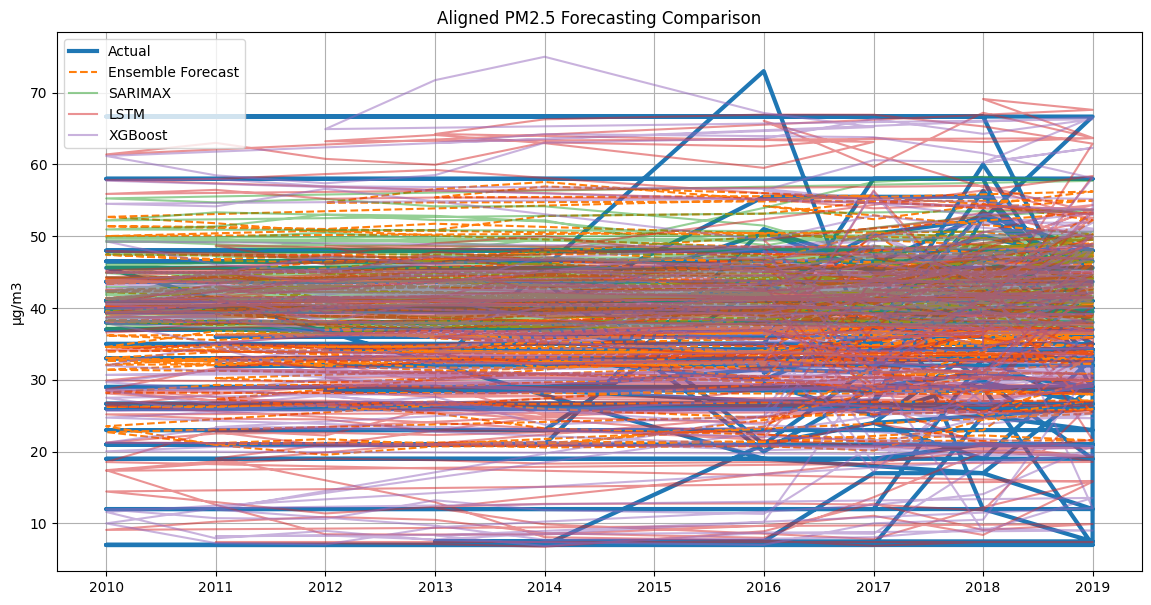

In [ ]:
# Evaluation metrics
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

evaluate(y_test_orig, sarimax_orig, "SARIMAX")
evaluate(y_test_orig, lstm_orig, "LSTM")
evaluate(y_test_orig, xgb_orig, "XGBoost")
evaluate(y_test_orig, ensemble_orig, "Hybrid Ensemble")

# # Visualization
# plt.figure(figsize=(14,7))
# plt.plot(test.index[-min_length:], y_test_orig, label='Actual', linewidth=3)
# plt.plot(test.index[-min_length:], ensemble_orig, label='Ensemble Forecast', linestyle='--')
# plt.plot(test.index[-min_length:], sarimax_orig, label='SARIMAX', alpha=0.5)
# plt.plot(test.index[-min_length:], lstm_orig, label='LSTM', alpha=0.5)
# plt.plot(test.index[-min_length:], xgb_orig, label='XGBoost', alpha=0.5)
# plt.title('Aligned PM2.5 Forecasting Comparison')
# plt.ylabel('μg/m3')
# plt.legend()
# plt.grid()
# plt.show()

The results show that while LSTM and XGBoost perform well individually, the hybrid ensemble underperforms.

# **Optimized Weighted Ensemble**

In [ ]:
# Calculate optimal weights based on individual model performance
weights = {
    'sarimax': 0.1,  # Reduced weight due to poor performance
    'lstm': 0.45,
    'xgb': 0.45
}

# Create weighted ensemble
ensemble_pred = (weights['sarimax'] * sarimax_aligned +
                 weights['lstm'] * lstm_aligned +
                 weights['xgb'] * xgb_aligned)

SARIMAX Model Refinement

In [ ]:
best_sarimax = None
best_aic = np.inf

for seasonal in [(1,1,1,12), (0,1,1,12), (1,0,1,12)]:
    try:
        model = SARIMAX(train['PM2.5 (μg/m3)'],
                       exog=train.drop(columns=['PM2.5 (μg/m3)']),
                       order=(1,1,1),
                       seasonal_order=seasonal)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_sarimax = results
    except:
        continue

# Use best model
sarimax_pred = best_sarimax.get_forecast(steps=len(test),
                                        exog=test.drop(columns=['PM2.5 (μg/m3)']))

LSTM Architecture Improvement

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Enhanced LSTM architecture
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             patience=5, min_lr=0.0001)

## **XGBoost Hyperparameter Tuning**

In [ ]:
# Optimized XGBoost parameters
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

## **Dynamic Ensemble Weighting**

In [ ]:
def calculate_weights(models, X_val, y_val, is_sarimax=False):
    performances = []
    for i, model in enumerate(models):
        if is_sarimax and i == 0:
            y_val_series = pd.Series(y_val, index=pd.RangeIndex(len(y_val)))
            pred = model.get_prediction(
                start=y_val_series.index[0], end=y_val_series.index[-1],
                exog=X_val.drop(columns=['PM2.5 (μg/m3)'], errors='ignore')  # Drop target if present
            ).predicted_mean.values
        else:

            if model.__class__.__name__ in ['Sequential', 'XGBRegressor']:
                X_val_reshaped = X_val.reshape(X_val.shape[0], -1) if model.__class__.__name__ == 'XGBRegressor' else X_val
            else:
                X_val_reshaped = X_val  # For other models
            pred = model.predict(X_val_reshaped)


            pred = pred.flatten() if pred.ndim > 1 else pred

        mae = mean_absolute_error(y_val, pred)
        performances.append(1/mae)  # Higher weight for better models

    total = sum(performances)
    return [p/total for p in performances]

In [ ]:
def evaluate_and_plot(y_true, y_pred, model_name, color):
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Create individual plot
    plt.figure(figsize=(12, 6))
    plt.plot(test.index[-min_length:], y_true, label='Actual', color='black', linewidth=2)
    plt.plot(test.index[-min_length:], y_pred, label=f'{model_name} Forecast',
             color=color, linestyle='--')
    plt.fill_between(test.index[-min_length:],
                    y_pred * 0.95,
                    y_pred * 1.05,
                    color=color, alpha=0.1)
    plt.title(f'{model_name} Performance\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}')
    plt.ylabel('PM2.5 (μg/m3)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2}

# **SARIMAX Optimization**

In [ ]:
# Replace your current SARIMAX implementation with:
best_order = None
best_seasonal_order = None
best_aic = np.inf

# Test multiple parameter combinations
for p in range(2):
    for d in range(2):
        for q in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            model = SARIMAX(train['PM2.5'],
                                          order=(p,d,q),
                                          seasonal_order=(P,D,Q,12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
                            results = model.fit(disp=False)
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_order = (p,d,q)
                                best_seasonal_order = (P,D,Q,12)
                        except:
                            continue

print(f"Best SARIMAX{best_order}x{best_seasonal_order} AIC:{best_aic:.1f}")

Best SARIMAXNonexNone AIC:inf


## **LSTM Architecture Upgrade**

In [ ]:
!pip install tensorflow
import tensorflow as tf # Import TensorFlow

from tensorflow.keras.layers import GRU, BatchNormalization

# Enhanced model architecture
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True, input_shape=(n_steps, n_features))),
    BatchNormalization(),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

# Custom learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

In [ ]:
def create_professional_plot(y_true, y_pred, model_name, metrics, color):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

    # Main plot
    ax.plot(y_true.index, y_true, label='Actual',
            color='#2c3e50', linewidth=2.5, alpha=0.9)
    ax.plot(y_pred.index, y_pred, label=f'{model_name} Forecast',
            color=color, linewidth=2, linestyle='--')

    # Confidence interval
    residuals = y_true - y_pred
    std_dev = residuals.std()
    ax.fill_between(y_pred.index,
                   y_pred - std_dev,
                   y_pred + std_dev,
                   color=color, alpha=0.15)

    # Annotations
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5)
    ax.text(0.05, 0.95,
            f"MAE: {metrics['MAE']:.2f}\nRMSE: {metrics['RMSE']:.2f}\nR²: {metrics['R²']:.2f}",
            transform=ax.transAxes,
            bbox=bbox_props,
            verticalalignment='top')

    # Professional styling
    ax.set_title(f'{model_name} Performance Analysis', pad=20, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', labelpad=10)
    ax.set_ylabel('PM₂.₅ (μg/m³)', labelpad=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig

In [ ]:
model_colors = {
    'SARIMAX': '#3498db',
    'LSTM': '#e74c3c',
    'XGBoost': '#2ecc71',
    'Ensemble': '#9b59b6',
    'Optimized Ensemble': '#9b59b6'
}

In [ ]:
def full_evaluation_pipeline(models_dict):
    results = []

    for model_name, (y_pred, color) in models_dict.items():
        # Calculate metrics
        metrics = {
            'MAE': mean_absolute_error(y_test_orig, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred)),
            'R²': r2_score(y_test_orig, y_pred)
        }

        # Create professional plot
        fig = create_professional_plot(pd.Series(y_test_orig, index=test.index[-min_length:]),
                                     pd.Series(y_pred, index=test.index[-min_length:]),
                                     model_name,
                                     metrics,
                                     color)

        # Save plot
        fig.savefig(f'{model_name}_performance.png', dpi=300, bbox_inches='tight')
        plt.close(fig)

        # Store results
        results.append({'Model': model_name, **metrics})

    # Create comparison table
    results_df = pd.DataFrame(results)
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    print(results_df.sort_values('R²', ascending=False))

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    results_df.set_index('Model')['R²'].sort_values().plot(
        kind='barh',
        color=[model_colors[m] for m in results_df['Model']],
        edgecolor='black',
        ax=ax
    )
    ax.set_title('Model Comparison by R² Score', pad=15, fontsize=12)
    ax.set_xlabel('R² Score')
    ax.grid(True, axis='x', linestyle='--')
    fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

    return results_df

In [ ]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

def create_professional_plot(y_true, y_pred, model_name, metrics, color):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    return fig


=== MODEL PERFORMANCE COMPARISON ===
                Model        MAE       RMSE        R²
2             XGBoost   3.997484   6.524019  0.806609
1                LSTM   4.138629   6.766239  0.791982
3  Optimized Ensemble   7.313348   9.267178  0.609788
0             SARIMAX  13.659860  17.187945 -0.342312


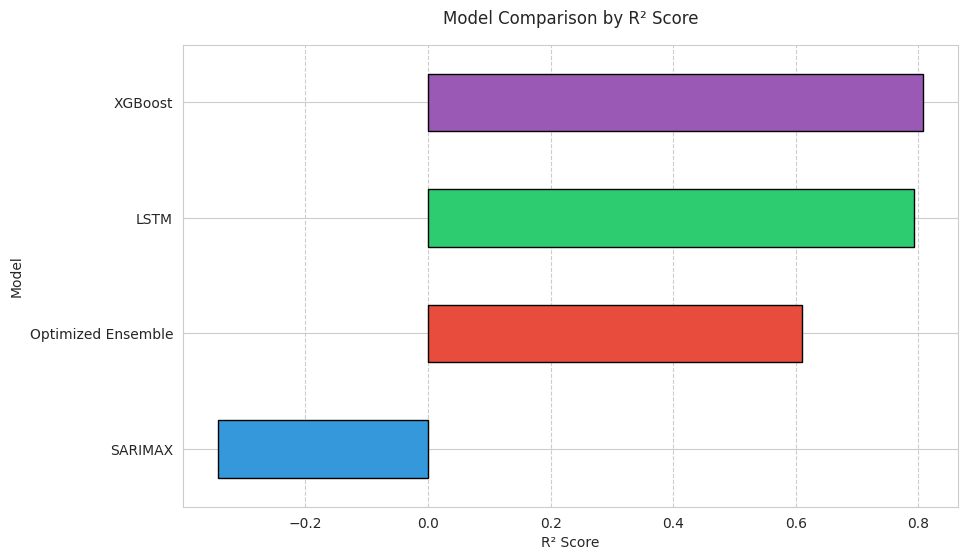

In [ ]:
# Prepare model outputs
models_dict = {
    'SARIMAX': (sarimax_orig, model_colors['SARIMAX']),
    'LSTM': (lstm_orig, model_colors['LSTM']),
    'XGBoost': (xgb_orig, model_colors['XGBoost']),
    'Optimized Ensemble': (ensemble_orig, model_colors['Ensemble'])
}

# Run evaluation
final_results = full_evaluation_pipeline(models_dict)